## Solving the equation using Autograd 

https://compphysics.github.io/MachineLearning/doc/pub/odenn/html/._odenn-bs024.html

C:\Users\KarlH\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Initial cost: 457.256
Final cost: 0.00310113
The max absolute difference between the solutions is: 0.000464088


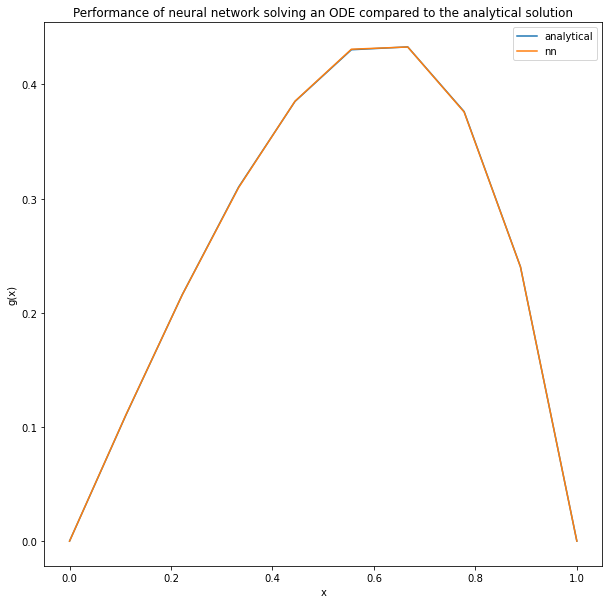

In [1]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from matplotlib import pyplot as plt

def sigmoid(z):
    return 1/(1 + np.exp(-z))

def deep_neural_network(deep_params, x):
    # N_hidden is the number of hidden layers
    N_hidden = np.size(deep_params) - 1 # -1 since params consist of parameters to all the hidden layers AND the output layer

    # Assumes input x being an one-dimensional array
    num_values = np.size(x)
    x = x.reshape(-1, num_values)

    # Assume that the input layer does nothing to the input x
    x_input = x

    # Due to multiple hidden layers, define a variable referencing to the
    # output of the previous layer:
    x_prev = x_input

    ## Hidden layers:

    for l in range(N_hidden):
        # From the list of parameters P; find the correct weigths and bias for this layer
        w_hidden = deep_params[l]

        # Add a row of ones to include bias
        x_prev = np.concatenate((np.ones((1,num_values)), x_prev ), axis = 0)

        z_hidden = np.matmul(w_hidden, x_prev)
        x_hidden = sigmoid(z_hidden)

        # Update x_prev such that next layer can use the output from this layer
        x_prev = x_hidden

    ## Output layer:

    # Get the weights and bias for this layer
    w_output = deep_params[-1]

    # Include bias:
    x_prev = np.concatenate((np.ones((1,num_values)), x_prev), axis = 0)

    z_output = np.matmul(w_output, x_prev)
    x_output = z_output

    return x_output

def solve_ode_deep_neural_network(x, num_neurons, num_iter, lmb):
    # num_hidden_neurons is now a list of number of neurons within each hidden layer

    # Find the number of hidden layers:
    N_hidden = np.size(num_neurons)

    ## Set up initial weigths and biases

    # Initialize the list of parameters:
    P = [None]*(N_hidden + 1) # + 1 to include the output layer

    P[0] = npr.randn(num_neurons[0], 2 )
    for l in range(1,N_hidden):
        P[l] = npr.randn(num_neurons[l], num_neurons[l-1] + 1) # +1 to include bias

    # For the output layer
    P[-1] = npr.randn(1, num_neurons[-1] + 1 ) # +1 since bias is included

    print('Initial cost: %g'%cost_function_deep(P, x))

    ## Start finding the optimal weigths using gradient descent

    # Find the Python function that represents the gradient of the cost function
    # w.r.t the 0-th input argument -- that is the weights and biases in the hidden and output layer
    cost_function_deep_grad = grad(cost_function_deep,0)

    # Let the update be done num_iter times
    for i in range(num_iter):
        # Evaluate the gradient at the current weights and biases in P.
        # The cost_grad consist now of N_hidden + 1 arrays; the gradient w.r.t the weights and biases
        # in the hidden layers and output layers evaluated at x.
        cost_deep_grad =  cost_function_deep_grad(P, x)

        for l in range(N_hidden+1):
            P[l] = P[l] - lmb * cost_deep_grad[l]

    print('Final cost: %g'%cost_function_deep(P, x))

    return P

## Set up the cost function specified for this Poisson equation:

# The right side of the ODE
def f(x):
    return (3*x + x**2)*np.exp(x)

def cost_function_deep(P, x):

    # Evaluate the trial function with the current parameters P
    g_t = g_trial_deep(x,P)

    # Find the derivative w.r.t x of the trial function
    d2_g_t = elementwise_grad(elementwise_grad(g_trial_deep,0))(x,P)

    right_side = f(x)

    err_sqr = (-d2_g_t - right_side)**2
    cost_sum = np.sum(err_sqr)

    return cost_sum/np.size(err_sqr)

# The trial solution:
def g_trial_deep(x,P):
    return x*(1-x)*deep_neural_network(P,x)

# The analytic solution;
def g_analytic(x):
    return x*(1-x)*np.exp(x)

if __name__ == '__main__':
    npr.seed(4155)

    ## Decide the vales of arguments to the function to solve
    Nx = 10
    x = np.linspace(0,1, Nx)

    ## Set up the initial parameters
    num_hidden_neurons = [200,100]
    num_iter = 1000
    lmb = 1e-3

    P = solve_ode_deep_neural_network(x, num_hidden_neurons, num_iter, lmb)

    g_dnn_ag = g_trial_deep(x,P)
    g_analytical = g_analytic(x)

    # Find the maximum absolute difference between the solutons:
    max_diff = np.max(np.abs(g_dnn_ag - g_analytical))
    print("The max absolute difference between the solutions is: %g"%max_diff)

    plt.figure(figsize=(10,10))

    plt.title('Performance of neural network solving an ODE compared to the analytical solution')
    plt.plot(x, g_analytical)
    plt.plot(x, g_dnn_ag[0,:])
    plt.legend(['analytical','nn'])
    plt.xlabel('x')
    plt.ylabel('g(x)')
    plt.show()